In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
# print(plt.style.available)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Initial Data Exploration

In [11]:
# Use the inspector to create column objects for each table in the Hawaii database
inspector = inspect(engine)
station_columns = inspector.get_columns('station')
measurement_columns = inspector.get_columns('measurement')

# Print column names and their data types for each of the two Classes in the Hawaii database
# for c in measurement_columns:
#     print(c['name'], c["type"])

In [12]:
# Turn table metadata into pandas dataframes
station_columns_df = pd.DataFrame(station_columns)
measurement_columns_df = pd.DataFrame(measurement_columns)
#station_columns_df

In [13]:
# Display the first row's columns and data in dictionary format
first_row = session.query(Measurement).first()
#first_row.__dict__

In [14]:
# Explore the Measurement Table
ex_m = session.query(Measurement.id, Measurement.tobs, Measurement.date, Measurement.prcp, Measurement.station)\
.order_by(Measurement.date).all()
#ex_m[1100:1110]

In [15]:
# Explore the Stations table
ex_s = session.query(Station.id, Station.station, Station.name).all()
#ex_s[0:10]

## Preciption Data Exploration

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [17]:
# Calculate the date 1 year ago from the last data point in the database
most_recent_date = session.query(func.max(Measurement.date)).all()[0][0]
most_recent_date_formatted = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
year_ago = most_recent_date_formatted - dt.timedelta(days=365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [18]:
# Gather only the most recent years length of precipitation data
year_prcp = (session.query(Measurement.prcp, Measurement.date, Measurement.station)
             .filter(Measurement.date > year_ago)
             .order_by(Measurement.date)
             .all())
year_prcp_df = pd.DataFrame(year_prcp).dropna().set_index("date")
year_prcp_df.head()

,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,2.15,USC00513117
2016-08-24,2.28,USC00514830
2016-08-24,1.22,USC00519523
2016-08-24,2.15,USC00519281


In [19]:
# Dataframe for the max level of percipitation recorded at any station per day (grouped by day)
# prcp_combined_stations = (session.query(func.max(Measurement.prcp).label('max_prcp'), Measurement.date)
#              .group_by(Measurement.date)
#              .filter(Measurement.date > year_ago)
#              .order_by(Measurement.date)
#              .all())
# prcp_combined_stations_df = pd.DataFrame(prcp_combined_stations).set_index("date")

In [20]:
# Plot the max precipitation value PER DAY (grouped by day) over the last year
# prcp_combined_stations_df.plot()
# plt.tight_layout()
# plt.show()

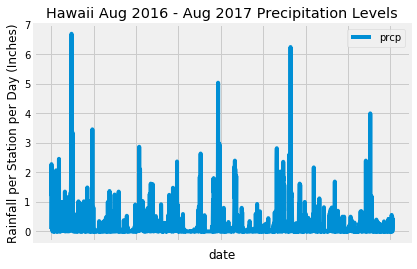

In [21]:
# Plot the most recent years precipitation data - every station, every day
year_prcp_df.plot()
plt.title("Hawaii Aug 2016 - Aug 2017 Precipitation Levels")
plt.ylabel("Rainfall per Station per Day (Inches)")
plt.show()

In [22]:
# Display the summary statistics for precipitation data per station by day
year_prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Staion and Temperature Data Exploration

In [23]:
# Design a query to show how many stations are available in this dataset
num_stations = session.query(func.count(Station.id)).all()[0][0]
num_stations

9

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order
most_active = session.query(func.count(Measurement.id).label("station_activity_count"), Measurement.station)\
                     .group_by(Measurement.station).all()
most_active_df = pd.DataFrame(most_active).sort_values(by=["station_activity_count"], ascending=False)\
                                          .set_index("station_activity_count")
most_active_df

,station
station_activity_count,
2772,USC00519281
2724,USC00519397
2709,USC00513117
2669,USC00519523
2612,USC00516128
2202,USC00514830
1979,USC00511918
1372,USC00517948
511,USC00518838


In [25]:
# Find the most active station

max_station_activity = session.query(func.count(Measurement.id).label("station_activity_count"), Measurement.station)\
                              .group_by(Measurement.station).order_by("station_activity_count").all()
station_w_most_activity = max_station_activity[-1][1]
station_w_most_activity

# An additional way to get this value
# station_most_activity = most_active_df.iloc[0,1]

'USC00519281'

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
max_temp_data_most_active_station = session.query(Measurement.station, func.min(Measurement.tobs))\
                                       .filter(Measurement.station == station_w_most_activity).all()
min_temp_data_most_active_station = session.query(Measurement.station, func.max(Measurement.tobs))\
                                       .filter(Measurement.station == station_w_most_activity).all()
avg_temp_data_most_active_station = session.query(Measurement.station, func.avg(Measurement.tobs))\
                                       .filter(Measurement.station == station_w_most_activity).all()
min_max_avg_temps = [max_temp_data_most_active_station[0][1], 
                     min_temp_data_most_active_station[0][1], 
                     avg_temp_data_most_active_station[0][1]]
min_max_avg_temps

[54.0, 85.0, 71.66378066378067]

In [42]:
# Query to find the last years worth of temperature data
year_temp = (session.query(Measurement.tobs, Measurement.date, Measurement.station)
             .filter(Measurement.date > year_ago)
             .order_by(Measurement.date)
             .all())
year_temp_df = pd.DataFrame(year_temp).dropna().set_index("date")
year_temp_df.head()

,tobs,station
date,,
2016-08-24,79.0,USC00519397
2016-08-24,76.0,USC00513117
2016-08-24,80.0,USC00514830
2016-08-24,78.0,USC00517948
2016-08-24,79.0,USC00519523


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
year_temp_most_active_station = (session.query(Measurement.tobs, Measurement.date, Measurement.station)
             .filter(Measurement.date > year_ago)
             .filter(Measurement.station == station_w_most_activity)
             .order_by(Measurement.date)
             .all())
year_temp_most_active_station_df = pd.DataFrame(year_temp_most_active_station).dropna().set_index("date")
year_temp_most_active_station_df.head(5)

,tobs,station
date,,
2016-08-24,77.0,USC00519281
2016-08-25,80.0,USC00519281
2016-08-26,80.0,USC00519281
2016-08-27,75.0,USC00519281
2016-08-28,73.0,USC00519281


In [29]:
# Add a column of 12 temperature bins
# lowest_temp = year_temp_most_active_station_df["tobs"].min()
# highest_temp = year_temp_most_active_station_df["tobs"].max()
# step = (highest_temp-lowest_temp)/13
# bins = (list(np.arange(lowest_temp,highest_temp,step)))
# bin_labels = ["59-60", "60-62", "62-64", "64-66", "66-68", "68-70", "70-71", "71-73", "73-75", "75-77", "77-79", "79-81"]
# year_temp_most_active_station_df["temp_bins"] = pd.cut(year_temp_most_active_station_df["tobs"], bins, labels=bin_labels)
# year_temp_most_active_station_df.head()

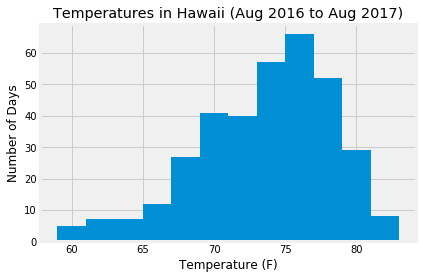

In [30]:
# Plot the temperatures collected from the most active station in Hawaii over the past year
plt.hist(x=year_temp_most_active_station_df["tobs"], bins=12)
plt.title("Temperatures in Hawaii (Aug 2016 to Aug 2017)")
plt.xlabel("Temperature (F)")
plt.ylabel("Number of Days")
plt.show()

## Optional: Other Recommended Analyses

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_vacation_temps = calc_temps('2017-05-04', '2017-05-10')

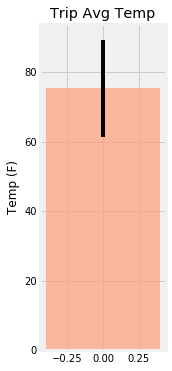

In [201]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = my_vacation_temps[0][0]
avg_temp = my_vacation_temps[0][1]
max_temp = my_vacation_temps[0][2]
plt.figure(figsize=(2,6))
plt.bar(x=0, height=avg_temp, color="lightsalmon", yerr=(max_temp - min_temp), alpha=0.7)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.show()

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

## Optional Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [38]:
# Plot the daily normals as an area plot with `stacked=False`
